## Deep Learning I
## Projeto Final

Membros: Anderson Silva, Bruno Pospichil, Diego Rosso, Julio Pires e Pedro Dutra.


#### Dataset escolhido: Malaria 
- Kaggle Mirror, Link: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria
- Fonte Original: National Library of Medicine, Link: https://lhncbc.nlm.nih.gov/publication/pub9932

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
import numpy as np
from glob import glob
from PIL import Image

In [0]:
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import models
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

from collections import defaultdict
import numpy as np

#### Download do dataset

Indicamos as seguintes opções para o download do dataset:
- Baixar o dataset pelo mirror link via kaggle acima e descompactar o conteúdo para a pasta `cell_images`. 
- Instalar o kaggle client e configurar a chave do kaggle na variavel `token` no código abaixo.

In [0]:
# Install kaggle packages
!pip install -q kaggle
!pip install -q kaggle-cli

!rm -rf /content/.kaggle/kaggle.json
import json
token = {"username":"xxxx","key":"xxxxx"}
!mkdir -p .kaggle
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
    
!chmod 600 /content/.kaggle/kaggle.json
!cp /content/.kaggle/kaggle.json /root/.kaggle/kaggle.json
!kaggle config set -n path -v/content

!kaggle datasets download iarunava/cell-images-for-detecting-malaria
!rm -rf cell_images
!unzip -q cell-images-for-detecting-malaria.zip

#### Git repository

Abaixo segue o repositório git contendo o código python no jupyter notebook e também o código LaTeX para gerar o report.


https://github.com/andersonnascimento/datascience-deeplearning-I


### PyTorch [Versão]

In [0]:
torch.__version__

'1.2.0'

### Configuração do Device (GPU / CPU)

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Definição do Seed

In [0]:
seed = 2019
np.random.seed(seed)
torch.manual_seed(seed)

### Métodos para processamento/visualização de imagens

In [0]:
def load_image(path):
    img = Image.open(path)
    return img.convert('RGB')

def plot_curves(loss_values, val_acc):
    '''
        Function to plot training loss 
        and validation accuracy
    '''
    fig, ax = plt.subplots(2, 1)
    ax[0].set_title('Training Loss')
    ax[0].plot(loss_values)
    ax[0].set_title('Loss')
    ax[0].set_xticks([])
    ax[1].set_title('Validation Accuracy')
    ax[1].plot(val_acc)
    ax[1].set_xticks([])

    
def plot_image(sample_img, sample_label):
    plt.imshow(sample_img)
    plt.title(f'Label: {sample_label}')
    plt.xticks([])
    plt.yticks([])

def plot_multiple_images(images, labels, n=6):
    fig, ax = plt.subplots(1,n, figsize=(30,30))
    for i, (img, label) in enumerate(zip(images, labels)):
        ax[i].imshow(img, )
        ax[i].set_title(f'Label: {label}')
        ax[i].set_xticks([])
        ax[i].set_yticks([])

##### Definição de Hiperparametros

In [0]:
batch_size = 32
num_workers = 0
nb_epochs = 10
log_interval = 200
lr = 0.001 
momentum=0.9

### Dataset:

In [0]:
path = 'cell_images/'

In [0]:
class MalariaDataset(torch.utils.data.Dataset):
    
    def __init__(self, path, transform=None):
        super().__init__()
        self.transform = transform
        self.images = glob(f'{path}/*/*.png')
        self.classes_str = [x.split('/')[-2] for x in self.images]
        self.class_set = sorted(list(set(self.classes_str)))
    
    def __getitem__(self, index):  
        image_path = self.images[index]
        label_str = self.classes_str[index]
        label_int = self.class_set.index(label_str)
        image = load_image(image_path)
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label_int
     
    def __len__(self):
        return len(self.images)

### Separação dos Dados: Treino, Teste e Validação

Train:  19292
Validation:  4133
Test:  4133
Total:  27558


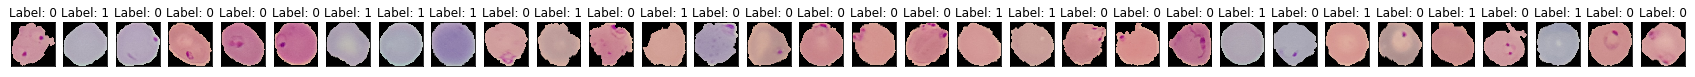

In [0]:
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor()])
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

cell_dataset = MalariaDataset(path, transform=transform)

split_15 = int(0.15 * len(cell_dataset))
index_list = list(range(len(cell_dataset)))
np.random.shuffle(index_list) 
validate_idx=index_list[:split_15]
test_idx=index_list[split_15:split_15*2]
train_idx = index_list[split_15*2:]

print('Train: ',len(train_idx))
print('Validation: ',len(validate_idx))
print('Test: ',len(test_idx))
print('Total: ', (len(train_idx)+len(validate_idx)+len(test_idx)))

train_loader = DataLoader(cell_dataset, batch_size=batch_size,sampler=SubsetRandomSampler(train_idx),num_workers=num_workers)
test_loader = DataLoader(cell_dataset, batch_size=batch_size,sampler=SubsetRandomSampler(test_idx),num_workers=num_workers)
validate_loader = DataLoader(cell_dataset, batch_size=batch_size,sampler=SubsetRandomSampler(validate_idx),num_workers=num_workers)

for images, labels_str in train_loader:
    plot_multiple_images(images.permute(0, 2, 3, 1), labels_str, n=batch_size)
    break

In [0]:
classes = cell_dataset.class_set
classes

['Parasitized', 'Uninfected']

In [0]:
def train_epoch(
        history_dict,
        model, 
        device, 
        train_loader, 
        optimizer, 
        criterion, 
        epoch, 
        log_interval        
    ):
    model.train()
    history = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        history_dict['loss'].append(loss.item())
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader)*batch_size,
                100. * batch_idx / len(train_loader), loss.item()))


def test(
        model, 
        device, 
        criterion, 
        test_loader
    ):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader)*batch_size
    accuracy = 100. * correct / (len(test_loader)*batch_size)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader)*batch_size,
        accuracy))
    return accuracy


def train(    
        history_dict,
        model,
        train_loader,
        test_loader,
        device,
        lr,
        nb_epochs=3,
        log_interval=100    
    ):
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
    criterion = nn.CrossEntropyLoss().to(device)

    for epoch in range(1, nb_epochs + 1):
        print('\n* * * Training * * *')
        train_epoch(
            history_dict=history_dict,
            model=model, 
            device=device, 
            train_loader=train_loader, 
            optimizer=optimizer, 
            criterion=criterion, 
            epoch=epoch, 
            log_interval=log_interval
        )
        print('\n* * * Evaluating * * *')
        acc = test(model, device, criterion, test_loader)   
        history_dict['val_acc'].append(acc)
    
    return acc

In [0]:
def calculate_accuracy(
        model, 
        device, 
        test_loader
    ):
    model.eval()
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    accuracy = 100. * correct / (len(test_loader)*batch_size)
    print('Accuracy: {}/{} ({:.2f}%)\n'.format(
        correct, len(test_loader)*batch_size, accuracy))
    return accuracy

### AlexNet

In [0]:
alex_net_full_dict = defaultdict(list)

alexnet_model = moO dels.alexnet(pretrained=False) 
alexnet_model.classifier  = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
)

alexnet_model = alexnet_model.to(device)
acc = train(alex_net_full_dict, alexnet_model, train_loader, validate_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))


* * * Training * * *
Train Epoch: 1 [0/19296 (0%)]	Loss: 0.692922
Train Epoch: 1 [6400/19296 (33%)]	Loss: 0.694997
Train Epoch: 1 [12800/19296 (66%)]	Loss: 0.693018
Train Epoch: 1 [19200/19296 (100%)]	Loss: 0.694448

* * * Evaluating * * *
Test set: Average loss: 0.0217, Accuracy: 2050/4160 (49.28%)


* * * Training * * *
Train Epoch: 2 [0/19296 (0%)]	Loss: 0.691913
Train Epoch: 2 [6400/19296 (33%)]	Loss: 0.690783
Train Epoch: 2 [12800/19296 (66%)]	Loss: 0.695853
Train Epoch: 2 [19200/19296 (100%)]	Loss: 0.692533

* * * Evaluating * * *
Test set: Average loss: 0.0217, Accuracy: 2050/4160 (49.28%)


* * * Training * * *
Train Epoch: 3 [0/19296 (0%)]	Loss: 0.693092
Train Epoch: 3 [6400/19296 (33%)]	Loss: 0.692656
Train Epoch: 3 [12800/19296 (66%)]	Loss: 0.692178
Train Epoch: 3 [19200/19296 (100%)]	Loss: 0.692937

* * * Evaluating * * *
Test set: Average loss: 0.0217, Accuracy: 2050/4160 (49.28%)


* * * Training * * *
Train Epoch: 4 [0/19296 (0%)]	Loss: 0.696170
Train Epoch: 4 [6400/192

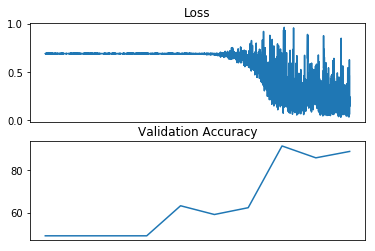

In [0]:
plot_curves(alex_net_full_dict['loss'], alex_net_full_dict['val_acc'])

### AlexNet com Fine-Tuning

In [0]:
alex_net_finetuning_dict = defaultdict(list)

alexnet_model_finetuning = models.alexnet(pretrained=True) 
alexnet_model_finetuning.classifier  = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 2),
)

alexnet_model_finetuning = alexnet_model_finetuning.to(device)
acc = train(alex_net_finetuning_dict, alexnet_model_finetuning, train_loader, validate_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))


* * * Training * * *
Train Epoch: 1 [0/19296 (0%)]	Loss: 0.684854
Train Epoch: 1 [6400/19296 (33%)]	Loss: 0.372766
Train Epoch: 1 [12800/19296 (66%)]	Loss: 0.085623
Train Epoch: 1 [19200/19296 (100%)]	Loss: 0.167795

* * * Evaluating * * *
Test set: Average loss: 0.0043, Accuracy: 3939/4160 (94.69%)


* * * Training * * *
Train Epoch: 2 [0/19296 (0%)]	Loss: 0.601470
Train Epoch: 2 [6400/19296 (33%)]	Loss: 0.021151
Train Epoch: 2 [12800/19296 (66%)]	Loss: 0.019017
Train Epoch: 2 [19200/19296 (100%)]	Loss: 0.175024

* * * Evaluating * * *
Test set: Average loss: 0.0038, Accuracy: 3968/4160 (95.38%)


* * * Training * * *
Train Epoch: 3 [0/19296 (0%)]	Loss: 0.113935
Train Epoch: 3 [6400/19296 (33%)]	Loss: 0.083379
Train Epoch: 3 [12800/19296 (66%)]	Loss: 0.146753
Train Epoch: 3 [19200/19296 (100%)]	Loss: 0.069849

* * * Evaluating * * *
Test set: Average loss: 0.0036, Accuracy: 3979/4160 (95.65%)


* * * Training * * *
Train Epoch: 4 [0/19296 (0%)]	Loss: 0.118694
Train Epoch: 4 [6400/192

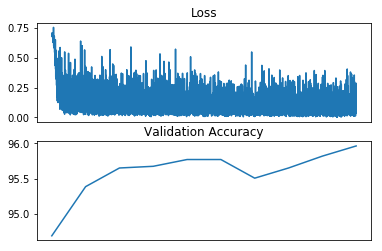

In [0]:
plot_curves(alex_net_finetuning_dict['loss'], alex_net_finetuning_dict['val_acc'])

### ResNet50

In [0]:
resnet50_history_dict = defaultdict(list)

resnet50_model = models.resnet50(pretrained=True) 
fc_in_features = resnet50_model.fc.in_features
resnet50_model.fc = nn.Linear(fc_in_features, 2)
resnet50_model = resnet50_model.to(device)
acc = train(resnet50_history_dict, resnet50_model, train_loader, validate_loader, device, lr, nb_epochs, log_interval)
print('Final acc: {:.2f}%'.format(acc))


* * * Training * * *
Train Epoch: 1 [0/19296 (0%)]	Loss: 0.734727
Train Epoch: 1 [6400/19296 (33%)]	Loss: 0.162210
Train Epoch: 1 [12800/19296 (66%)]	Loss: 0.036819
Train Epoch: 1 [19200/19296 (100%)]	Loss: 0.026808

* * * Evaluating * * *
Test set: Average loss: 0.0028, Accuracy: 4003/4160 (96.23%)


* * * Training * * *
Train Epoch: 2 [0/19296 (0%)]	Loss: 0.166952
Train Epoch: 2 [6400/19296 (33%)]	Loss: 0.012621
Train Epoch: 2 [12800/19296 (66%)]	Loss: 0.027026
Train Epoch: 2 [19200/19296 (100%)]	Loss: 0.068491

* * * Evaluating * * *
Test set: Average loss: 0.0028, Accuracy: 4014/4160 (96.49%)


* * * Training * * *
Train Epoch: 3 [0/19296 (0%)]	Loss: 0.083158
Train Epoch: 3 [6400/19296 (33%)]	Loss: 0.003224
Train Epoch: 3 [12800/19296 (66%)]	Loss: 0.043852
Train Epoch: 3 [19200/19296 (100%)]	Loss: 0.063198

* * * Evaluating * * *
Test set: Average loss: 0.0025, Accuracy: 4016/4160 (96.54%)


* * * Training * * *
Train Epoch: 4 [0/19296 (0%)]	Loss: 0.077945
Train Epoch: 4 [6400/192

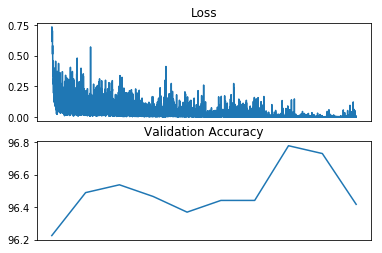

In [0]:
plot_curves(resnet50_history_dict['loss'], resnet50_history_dict['val_acc'])

### Avaliação Final

#### AlexNet

In [0]:
calculate_accuracy(alexnet_model, device, test_loader)

Accuracy: 3726/4160 (89.57%)



89.5673076923077

#### AlexNet com Fine-Tuning

In [0]:
calculate_accuracy(alexnet_model_finetuning, device, test_loader)

Accuracy: 3977/4160 (95.60%)



95.60096153846153

#### ResNet50

In [0]:
calculate_accuracy(resnet50_model, device, test_loader)

Accuracy: 4004/4160 (96.25%)



96.25